# 1. General Problem Set-up

## Import packages

In [1]:
import pandas as pd
import numpy as np

## Import LCA matrices from OpenLCA

In [2]:
A_df = pd.read_csv("data/A.csv", header=None)
B_df = pd.read_csv("data/B.csv", header=None)
C_df = pd.read_csv("data/C.csv", header=None)

# Convert all string-looking numbers to floats
A = A_df.apply(pd.to_numeric, errors='coerce').values
B = B_df.apply(pd.to_numeric, errors='coerce').values
C = C_df.apply(pd.to_numeric, errors='coerce').values

In [3]:
A_index_df = pd.read_csv("data/index_A.csv")
B_index_df = pd.read_csv("data/index_B.csv")
C_index_df = pd.read_csv("data/index_C.csv")

## Removing Transportation (deregionalization)

In [4]:
A_transport_df = pd.read_csv("data/Transportation_A.csv")

In [5]:
# create a dict mapping each provider name to all its indices in A_index_df
mapping = A_index_df.groupby('provider name')['index'].apply(list)

# build a single flat list of all matching indices for the foreground processes
matched_indices_transport = [
    idx
    for name in A_transport_df['provider name']
    if name in mapping
    for idx in mapping[name]
]

In [6]:
import numpy as np

# matched_indices_transport is the list of indices to remove
to_drop = np.array(sorted(set(matched_indices_transport), key=int))

# 1) Remove from A_index_df
mask_keep = ~A_index_df['index'].isin(to_drop)
A_index_df = A_index_df.loc[mask_keep].copy()

# 2) Remove corresponding rows and columns from A
A = np.delete(A, to_drop, axis=0)  # remove rows
A = np.delete(A, to_drop, axis=1)  # remove columns

# 3) Remove the same columns from B (keep rows)
B = np.delete(B, to_drop, axis=1)

# 4) Reset the index column in A_index_df
A_index_df['index'] = np.arange(len(A_index_df), dtype=int)

## Aggregating electricity

In [7]:
A_elec_df = pd.read_csv("data/Electricity_A.csv")

In [8]:
# Inputs assumed:
# A : numeric numpy array (rows x cols)
# A_index_df : DataFrame with columns ["index", "provider name", "flow name", ...]
# A_elec_df : DataFrame with column ["provider name"] listing all electricity providers
# The indices in A_index_df["index"] align with both row and column positions of A.

# 0) Build the set of electricity provider names
elec_names = set(A_elec_df['provider name'].dropna().astype(str).unique())

# 1) Find their indices in A_index_df
elec_idx = A_index_df.loc[A_index_df['provider name'].astype(str).isin(elec_names), 'index'].astype(int).unique()

# 2) Locate the mix row index (must exist)
mix_name = "Electricity Mix (Global)"
mix_rows = A_index_df.loc[A_index_df['provider name'] == mix_name, 'index'].astype(int).unique()
if len(mix_rows) == 0:
    raise ValueError("Electricity Mix (Global) not found in A_index_df['provider name'].")
mix_idx = int(mix_rows[0])

# Ensure the mix row is not purged
elec_idx_set = set(map(int, elec_idx))
elec_idx_wo_mix = sorted(elec_idx_set - {mix_idx})

# 3) Aggregate: add all electricity rows (except the mix row) into the mix row, column-wise
if len(elec_idx_wo_mix) > 0:
    # in case of NaNs
    add_block = np.nansum(A[elec_idx_wo_mix, :], axis=0)
    A[mix_idx, :] = np.nan_to_num(A[mix_idx, :]) + np.nan_to_num(add_block)

# 4) Decide what to drop
rows_to_drop = np.array(elec_idx_wo_mix, dtype=int)            # drop electricity rows except the mix row
cols_to_drop = np.array(elec_idx_wo_mix, dtype=int)            # drop electricity columns except the mix column

# (Optionally also drop the mix COLUMN; keep it if you want to retain that process as a column)
# To ALSO drop the mix column, uncomment the next line:
# cols_to_drop = np.array(sorted(elec_idx_set), dtype=int)

# 5) Remove rows/columns from A and columns from B
if rows_to_drop.size > 0:
    A = np.delete(A, rows_to_drop, axis=0)
if cols_to_drop.size > 0:
    A = np.delete(A, cols_to_drop, axis=1)
    B = np.delete(B, cols_to_drop, axis=1)

# 6) Remove the same rows from A_index_df (only rows; columns in A_index_df are metadata)
if len(elec_idx_wo_mix) > 0:
    keep_mask = ~A_index_df['index'].astype(int).isin(elec_idx_wo_mix)
    A_index_df = A_index_df.loc[keep_mask].copy()

# 7) Reset the "index" column in A_index_df to reflect 0..n-1 after deletions
A_index_df['index'] = np.arange(len(A_index_df), dtype=int)

In [9]:
# Global Electricity Mix for 2025
electricity_mix_df = pd.read_csv("data/electricity_mix.csv")

In [10]:
import numpy as np
import pandas as pd

# --- helpers ---
norm = lambda s: str(s).strip().casefold()

# copies + normalized keys
A_index_df = A_index_df.copy()
electricity_mix_df = electricity_mix_df.copy()

A_index_df["provider_key"] = A_index_df["provider name"].map(norm)
electricity_mix_df["provider_key"] = electricity_mix_df["provider name"].map(norm)

# map: provider_key -> list of row indices in A (these are the *rows*)
row_idx_map = (
    A_index_df.groupby("provider_key")["index"]
    .apply(lambda s: list(map(int, s)))
    .to_dict()
)

# find the *column* indices in A for each target electricity column
def get_col_idx(label: str) -> int:
    key = norm(label)
    arr = A_index_df.loc[A_index_df["provider_key"] == key, "index"].astype(int).values
    if len(arr) == 0:
        raise ValueError(f"'{label}' not found in A_index_df['provider name']")
    return int(arr[0])

col_map = {
    "Fossil Electricity - 2025":      get_col_idx("Fossil Electricity"),
    "Clean Electricity - 2025":       get_col_idx("Clean Electricity"),
    "2025 Energy Mix":                get_col_idx("Electricity Mix (Global)"),
}

# ensure numeric inputs; keep NaN to skip writes cleanly
for src_col in list(col_map.keys()):
    if src_col not in electricity_mix_df.columns:
        raise ValueError(f"Source column '{src_col}' not found in electricity_mix_df")
    electricity_mix_df[src_col] = pd.to_numeric(electricity_mix_df[src_col], errors="coerce")

# --- assign values into A ---
for _, row in electricity_mix_df.iterrows():
    pkey = row["provider_key"]
    rows = row_idx_map.get(pkey, [])
    if not rows:
        continue  # provider not in A_index_df rows — skip

    for src_col, target_col_idx in col_map.items():
        val = row[src_col]
        if pd.isna(val):
            continue  # nothing to write
        v = float(val)
        for r in rows:
            A[int(r), target_col_idx] = v


## Quality Scenario (for recycled material from mechanical)

In [11]:
quality_scenarios_df = pd.read_csv("data/quality_scenarios.csv")

In [12]:
# Assumes the following are already in memory:
# - quality_scenarios_df  with columns: "Recycling Process", "Substitutable Virgin Process", "S1 - no limit"
# - A_index_df            with columns: "Provider name", "Index"
# - A                     as a NumPy array (your A-matrix)

# Normalize helper (case-insensitive, trim spaces)
_norm = lambda s: str(s).strip().casefold()

# Build name -> index map from A_index_df
# If A_index_df['Index'] is 1-based, uncomment the "- 1" line below instead.
name_to_idx = {
    _norm(p): int(i)
    for p, i in zip(A_index_df["provider name"], A_index_df["index"])
    # for p, i in zip(A_index_df["Provider name"], A_index_df["Index"] - 1)  # <- use this if indices are 1-based
}

# Map processes to A indices
col_idx = quality_scenarios_df["Recycling Process"].astype(str).map(_norm).map(name_to_idx)
row_idx = quality_scenarios_df["Substitutable Virgin Process"].astype(str).map(_norm).map(name_to_idx)

# Save the pair (row, col) to the "Index" column
quality_scenarios_df["index"] = list(zip(row_idx, col_idx))

# Pull values to write
vals = pd.to_numeric(quality_scenarios_df["S1 - no limit"], errors="coerce")

# Only update where both indices and value are valid
mask = row_idx.notna() & col_idx.notna() & vals.notna()
rows = row_idx[mask].astype(int).to_numpy()
cols = col_idx[mask].astype(int).to_numpy()
v    = vals[mask].to_numpy(dtype=float)

# Write into A at (row, col)
A[rows, cols] = v

# Optional diagnostics:
# print("Updated entries:", mask.sum())
# print("Unmatched Recycling Process:", quality_scenarios_df.loc[col_idx.isna(), "Recycling Process"].drop_duplicates().tolist()[:10])
# print("Unmatched Substitutable Virgin Process:", quality_scenarios_df.loc[row_idx.isna(), "Substitutable Virgin Process"].drop_duplicates().tolist()[:10])


In [13]:
A[int(A_index_df.loc[A_index_df["provider name"]=="Polyethylene, high density, HDPE, virgin resin, food non-bottle grade","index"].iloc[0]),
  int(A_index_df.loc[A_index_df["provider name"]=="Mechanical Recycling, HDPE Other Food Rigid (Flakes)","index"].iloc[0])]

1.0

## Identifying background flows for cost calculation

In [14]:
A_foreground_df = pd.read_csv("data/Foreground_A.csv")

In [15]:
import numpy as np
import pandas as pd

# Helper for consistent comparison
norm = lambda s: str(s).strip().casefold()

# Normalize keys
A_index_df = A_index_df.copy()
A_foreground_df = A_foreground_df.copy()
A_index_df['provider_key'] = A_index_df['provider name'].map(norm)
A_foreground_df['provider_key'] = A_foreground_df['provider name'].map(norm)

# Build mapping from provider -> indices
idx_map = (
    A_index_df
    .groupby('provider_key')['index']
    .apply(lambda s: list(map(int, s)))
    .to_dict()
)

# Foreground indices (to exclude later)
matched_indices = sorted({
    idx
    for key in A_foreground_df['provider_key'].unique()
    for idx in idx_map.get(key, [])
})

# Example: build all_nonzero from the numeric matrix A
# (take all row indices with nonzero entries across the columns in matched_indices)
all_nonzero = set()
for col in matched_indices:
    all_nonzero.update(np.nonzero(A[:, col])[0])

# Remove overlap
foreground_set = set(matched_indices)
all_nonzero_set = {int(x) for x in all_nonzero}
filtered_nonzero_rows = sorted(all_nonzero_set - foreground_set)


In [16]:
result_df = A_index_df[A_index_df['index'].isin(filtered_nonzero_rows)].copy()

In [17]:
result_df.to_csv('filtered_nonzero_rows_with_names.csv', index=False)

## Importing financial data for cost calculation

In [18]:
financial_df = pd.read_csv("data/Financial.csv")

# 2. Static Analysis and Optimization

## 2.1. Base Case (Linear fossil economy in 2025 without carbon capture and microplastic treatment)

### Electricity Mix

In [32]:
# Global Electricity Mix for 2025
electricity_mix_df = pd.read_csv("data/electricity_mix.csv")

In [33]:
import numpy as np
import pandas as pd

# --- helpers ---
norm = lambda s: str(s).strip().casefold()

# copies + normalized keys
A_index_df = A_index_df.copy()
electricity_mix_df = electricity_mix_df.copy()

A_index_df["provider_key"] = A_index_df["provider name"].map(norm)
electricity_mix_df["provider_key"] = electricity_mix_df["provider name"].map(norm)

# map: provider_key -> list of row indices in A (these are the *rows*)
row_idx_map = (
    A_index_df.groupby("provider_key")["index"]
    .apply(lambda s: list(map(int, s)))
    .to_dict()
)

# find the *column* indices in A for each target electricity column
def get_col_idx(label: str) -> int:
    key = norm(label)
    arr = A_index_df.loc[A_index_df["provider_key"] == key, "index"].astype(int).values
    if len(arr) == 0:
        raise ValueError(f"'{label}' not found in A_index_df['provider name']")
    return int(arr[0])

col_map = {
    "Fossil Electricity - 2025":      get_col_idx("Fossil Electricity"),
    "Clean Electricity - 2025":       get_col_idx("Clean Electricity"),
    "2025 Energy Mix":                get_col_idx("Electricity Mix (Global)"),
}

# ensure numeric inputs; keep NaN to skip writes cleanly
for src_col in list(col_map.keys()):
    if src_col not in electricity_mix_df.columns:
        raise ValueError(f"Source column '{src_col}' not found in electricity_mix_df")
    electricity_mix_df[src_col] = pd.to_numeric(electricity_mix_df[src_col], errors="coerce")

# --- assign values into A ---
for _, row in electricity_mix_df.iterrows():
    pkey = row["provider_key"]
    rows = row_idx_map.get(pkey, [])
    if not rows:
        continue  # provider not in A_index_df rows — skip

    for src_col, target_col_idx in col_map.items():
        val = row[src_col]
        if pd.isna(val):
            continue  # nothing to write
        v = float(val)
        for r in rows:
            A[int(r), target_col_idx] = v


In [34]:
A[int(A_index_df.loc[A_index_df["provider name"]=="Electricity, hydropower (life cycle)","index"].iloc[0]),
  int(A_index_df.loc[A_index_df["provider name"]=="Clean Electricity","index"].iloc[0])]

-0.35

### Collection and Sorting

In [35]:
packaging_types_df = pd.read_csv("data/packaging_types.csv")
collection_recyclate_df = pd.read_csv("data/collection_Recyclate.csv")
collection_msw_df = pd.read_csv("data/collection_MSW.csv")

In [36]:
import numpy as np
import pandas as pd
import re

# ---- exact-key matcher (case/space insensitive, keeps stage prefixes) ----
ekey = lambda s: str(s).strip().casefold()

# ---- copies + normalized keys ----
A_index_df = A_index_df.copy()
packaging_types_df = packaging_types_df.copy()
collection_msw_df = collection_msw_df.copy()

A_index_df["prov_exact"]         = A_index_df["provider name"].map(ekey)
packaging_types_df["prov_exact"] = packaging_types_df["provider name"].map(ekey)
collection_msw_df["prov_exact"]  = collection_msw_df["provider name"].map(ekey)

# If you know the 3 mapping columns, set them here, e.g.:
# mapping_cols = ["dest_1", "dest_2", "dest_3"]
# Otherwise, auto-detect up to 3 string columns besides 'provider name'
mapping_cols = [c for c in packaging_types_df.columns
                if c not in ("provider name", "prov_exact")
                and pd.api.types.is_string_dtype(packaging_types_df[c])][:3]
if not mapping_cols:
    raise ValueError("Couldn't detect mapping columns; please set 'mapping_cols' explicitly.")

# Normalize destination columns
for col in mapping_cols:
    packaging_types_df[col + "_exact"] = packaging_types_df[col].map(ekey)

# provider name -> list of integer indices in A (rows/cols)
idx_map_exact = (
    A_index_df.groupby("prov_exact")["index"]
              .apply(lambda s: list(map(int, s)))
              .to_dict()
)

# "Use & Collection" column index
use_col = int(A_index_df.loc[A_index_df["provider name"]=="Use & Collection","index"].iloc[0])

# ---- X: abs(A[row, use_col]) per packaging provider (exact match) ----
X_by_src = {}
for k in packaging_types_df["prov_exact"].dropna().unique():
    rows = idx_map_exact.get(k, [])
    if rows:
        r0 = int(rows[0])  # if multiple rows per provider, change to sum/mean if needed
        X_by_src[k] = abs(float(A[r0, use_col]))

# ---- Y: MSW "Linear Economy" per provider (exact match) ----
Y_by_key = (collection_msw_df.dropna(subset=["prov_exact"])
            .groupby("prov_exact")["Linear Economy"]
            .first()
            .to_dict())

# ---- zero out destination cells we're going to rewrite (avoid accumulation on reruns) ----
dest_rows = set()
for _, row in packaging_types_df.iterrows():
    for col in mapping_cols:
        dk = row.get(col + "_exact", None)
        if dk in idx_map_exact:
            dest_rows.update(idx_map_exact[dk])
if dest_rows:
    A[list(dest_rows), use_col] = 0.0

# ---- assign: A[row, use_col] += X * Y for each mapped destination (exact match) ----
for _, row in packaging_types_df.iterrows():
    src_k = row["prov_exact"]
    X     = X_by_src.get(src_k)
    if X is None:
        continue
    for col in mapping_cols:
        dk = row.get(col + "_exact", None)
        if not dk:
            continue
        Y = Y_by_key.get(dk)
        if Y is None or pd.isna(Y):
            continue
        contrib = float(abs(X) * float(Y))
        for r in idx_map_exact.get(dk, []):
            A[int(r), use_col] += contrib

In [37]:
A[int(A_index_df.loc[A_index_df["provider name"]=="Disposal, Multi-material Food Bottles","index"].iloc[0]),
  int(A_index_df.loc[A_index_df["provider name"]=="Use & Collection","index"].iloc[0])]

0.021840000000000002

In [38]:
# --- Recyclate pass: X * Y_recyclate added into A[:, use_col] ---

collection_recyclate_df = collection_recyclate_df.copy()
collection_recyclate_df["prov_exact"] = collection_recyclate_df["provider name"].map(ekey)

# Y from recyclate
Y_rec_by_key = (
    collection_recyclate_df.dropna(subset=["prov_exact"])
    .groupby("prov_exact")["Linear Economy"]
    .first()    # change to sum()/mean() if needed
    .to_dict()
)

# Optionally clear destination cells before this pass (default = keep MSW values and add recyclate)
reset_dest = False
if reset_dest:
    rec_dest_rows = set()
    for _, row in packaging_types_df.iterrows():
        for col in mapping_cols:
            dk = row.get(col + "_exact", None)
            rec_dest_rows.update(idx_map_exact.get(dk, []))
    if rec_dest_rows:
        A[np.array(sorted(rec_dest_rows), dtype=int), use_col] = 0.0

# Write: A[row, use_col] += X * Y_recyclate
for _, row in packaging_types_df.iterrows():
    src_k = row["prov_exact"]
    X = X_by_src.get(src_k)
    if X is None:
        continue
    for col in mapping_cols:
        dk = row.get(col + "_exact", None)
        if not dk:
            continue
        Y = Y_rec_by_key.get(dk)
        if Y is None or pd.isna(Y):
            continue
        contrib = float(abs(X) * float(Y))
        for r in idx_map_exact.get(dk, []):
            A[int(r), use_col] += contrib

In [39]:
A[int(A_index_df.loc[A_index_df["provider name"]=="High-tech Sorting, Collected HDPE Drinking Bottles","index"].iloc[0]),
  int(A_index_df.loc[A_index_df["provider name"]=="Use & Collection","index"].iloc[0])]

0.0

### Monomers

In [40]:
monomers_decisions_df = pd.read_csv("data/monomers_decisions.csv")

In [41]:
import numpy as np
import pandas as pd

# ---- helper: normalize names for reliable matching ----
ekey = lambda s: str(s).strip().casefold()

# ---- defensive copies + normalized keys ----
A_index_df = A_index_df.copy()
monomers_decisions_df = monomers_decisions_df.copy()

A_index_df["prov_key"] = A_index_df["provider name"].map(ekey)
monomers_decisions_df["col_key"]  = monomers_decisions_df["Provider name"].map(ekey)
monomers_decisions_df["row_key"]  = monomers_decisions_df["Input parameters names"].map(ekey)

# provider key -> list of integer indices in A (rows/cols)
idx_map = (
    A_index_df.groupby("prov_key")["index"]
    .apply(lambda s: list(map(int, s)))
    .to_dict()
)

# ensure "Linear Economy" is numeric
monomers_decisions_df["Linear Economy"] = pd.to_numeric(
    monomers_decisions_df["Linear Economy"], errors="coerce"
)

# ---- apply updates: for each row in decisions, scale A[row_idx, col_idx] *= X ----
n_pairs = 0
skipped = 0

for _, drow in monomers_decisions_df.iterrows():
    x = drow["Linear Economy"]
    if pd.isna(x):
        skipped += 1
        continue

    row_idxs = idx_map.get(drow["row_key"], [])
    col_idxs = idx_map.get(drow["col_key"], [])

    if not row_idxs or not col_idxs:
        skipped += 1
        continue

    # multiply all combinations (row, col) by X
    for ri in row_idxs:
        for ci in col_idxs:
            A[int(ri), int(ci)] = np.nan_to_num(A[int(ri), int(ci)]) * float(x)
            n_pairs += 1

In [42]:
A[int(A_index_df.loc[A_index_df["provider name"]=="Ethylene production, fossil, steam cracker","index"].iloc[0]),
  int(A_index_df.loc[A_index_df["provider name"]=="Ethylene","index"].iloc[0])]

-1.0

### Carbon Capture

In [43]:
carbon_capture_decisions_df = pd.read_csv("data/carbon_capture_decisions.csv")

In [44]:
import numpy as np
import pandas as pd

# Helper to normalize keys (to avoid case/space mismatches)
norm = lambda s: str(s).strip().casefold()

# Normalize provider names in both DataFrames
A_index_df = A_index_df.copy()
electricity_mix_df = electricity_mix_df.copy()
A_index_df['provider_key'] = A_index_df['provider name'].map(norm)
electricity_mix_df['provider_key'] = electricity_mix_df['provider name'].map(norm)

# Find the column index for "Electricity Mix (Global)"
mix_key = norm("Electricity Mix (Global)")
mix_idx_arr = A_index_df.loc[A_index_df['provider_key'] == mix_key, 'index'].astype(int).values
if len(mix_idx_arr) == 0:
    raise ValueError("'Electricity Mix (Global)' not found in A_index_df['provider name']")
mix_col = int(mix_idx_arr[0])

# Iterate over providers in electricity_mix_df and assign values into A
for _, row in electricity_mix_df.iterrows():
    prov_key = row['provider_key']
    energy_val = row['2025 Energy Mix']

    # find the row index (from A_index_df) for this provider
    idxs = A_index_df.loc[A_index_df['provider_key'] == prov_key, 'index'].astype(int).values
    for ridx in idxs:
        A[ridx, mix_col] = energy_val

In [45]:
import numpy as np
import pandas as pd

# normalize for reliable matching
ekey = lambda s: str(s).strip().casefold()

# copies + keys
A_index_df = A_index_df.copy()
carbon_capture_decisions_df = carbon_capture_decisions_df.copy()

A_index_df["prov_key"] = A_index_df["provider name"].map(ekey)
carbon_capture_decisions_df["col_key"] = carbon_capture_decisions_df["Provider name"].map(ekey)
carbon_capture_decisions_df["row_key"] = carbon_capture_decisions_df["Input parameters names"].map(ekey)

# provider key -> list of integer indices (row/col) in A
idx_map = (
    A_index_df.groupby("prov_key")["index"]
    .apply(lambda s: list(map(int, s)))
    .to_dict()
)

# ensure numeric X
carbon_capture_decisions_df["Linear Economy"] = pd.to_numeric(
    carbon_capture_decisions_df["Linear Economy"], errors="coerce"
)

# apply: for each decision row, A[row, col] *= X
n_pairs = 0
skipped = 0

for _, d in carbon_capture_decisions_df.iterrows():
    X = d["Linear Economy"]
    if pd.isna(X):
        skipped += 1
        continue

    row_idxs = idx_map.get(d["row_key"], [])
    col_idxs = idx_map.get(d["col_key"], [])

    if not row_idxs or not col_idxs:
        skipped += 1
        continue

    for ri in row_idxs:
        for ci in col_idxs:
            A[int(ri), int(ci)] = np.nan_to_num(A[int(ri), int(ci)]) * float(X)
            n_pairs += 1

In [46]:
A[int(A_index_df.loc[A_index_df["provider name"]=="Plastic Incineration CO2 to the atmosphere","index"].iloc[0]),
  int(A_index_df.loc[A_index_df["provider name"]=="Plastic Incineration CO2","index"].iloc[0])]

1.0

### microplastics treatment

In [47]:
microplastics_decisions_df = pd.read_csv("data/microplastics_decisions.csv")

In [48]:
import numpy as np
import pandas as pd

# normalizer
ekey = lambda s: str(s).strip().casefold()

# copies + normalized keys
A_index_df = A_index_df.copy()
microplastics_decisions_df = microplastics_decisions_df.copy()

A_index_df["prov_key"] = A_index_df["provider name"].map(ekey)
microplastics_decisions_df["col_key"] = microplastics_decisions_df["Provider name"].map(ekey)
microplastics_decisions_df["row_key"] = microplastics_decisions_df["Input parameters names"].map(ekey)

# provider key -> list of integer indices in A (rows/cols)
idx_map = (
    A_index_df.groupby("prov_key")["index"]
    .apply(lambda s: list(map(int, s)))
    .to_dict()
)

# ensure numeric decision value
microplastics_decisions_df["Linear Economy"] = pd.to_numeric(
    microplastics_decisions_df["Linear Economy"], errors="coerce"
)

# apply decisions: A[row, col] *= value
n_pairs = 0
skipped = 0

for _, d in microplastics_decisions_df.iterrows():
    x = d["Linear Economy"]
    if pd.isna(x):
        skipped += 1
        continue

    row_idxs = idx_map.get(d["row_key"], [])
    col_idxs = idx_map.get(d["col_key"], [])

    if not row_idxs or not col_idxs:
        skipped += 1
        continue

    for ri in row_idxs:
        for ci in col_idxs:
            A[int(ri), int(ci)] = np.nan_to_num(A[int(ri), int(ci)]) * float(x)
            n_pairs += 1

In [49]:
A[int(A_index_df.loc[A_index_df["provider name"]=="Plastic Incineration CO2 to the atmosphere","index"].iloc[0]),
  int(A_index_df.loc[A_index_df["provider name"]=="Plastic Incineration CO2","index"].iloc[0])]

1.0

### LCA/TEA Calculations

In [50]:
# LCA Calculations
packaging_demand_2025 = 4.29e+11 #429 MMT
f = np.zeros(len(A))
f[0] = packaging_demand_2025
s = np.linalg.solve(A, f)
g = B@s
phi = C@g
phi_normalized = phi/packaging_demand_2025

In [51]:
# LCA Hotspots
# Impact per provider for category 0
CB = C @ B                                  # (n_impacts × n_providers)
contrib = s * CB[0, :]                      # contribution per provider
total_phi0 = contrib.sum()

# Use provider names from A_index_df
df = pd.DataFrame({
    "provider_name": A_index_df["provider name"].values,  # adjust column name if needed
    "contribution": contrib
})
df["share_%"] = 100 * df["contribution"] / total_phi0

# Top 10 contributors (by signed value)
top10 = df.sort_values("contribution", ascending=False).head(10)
print("\nTop 10 contributors to phi[0]:")
print(top10.reset_index(drop=True))

# If you want absolute-value ranking (credits vs burdens):
top10_abs = df.iloc[df["contribution"].abs().sort_values(ascending=False).index].head(10)
print("\nTop 10 contributors to phi[x] (absolute):")
print(top10_abs.reset_index(drop=True))


Top 10 contributors to phi[0]:
                                       provider_name  contribution    share_%
0                     Electricity, coal (life cycle)  2.128320e+11  14.294350
1                Steam Cracker CO2 to the atmosphere  2.054939e+11  13.801505
2         Plastic Incineration CO2 to the atmosphere  1.908820e+11  12.820128
3  Natural gas, combusted in industrial boiler, a...  1.712721e+11  11.503079
4        Natural gas, combusted in industrial boiler  9.676834e+10   6.499212
5              Electricity, natural gas (life cycle)  6.687861e+10   4.491740
6                    Petroleum refining, at refinery  5.845680e+10   3.926110
7                                   Open Burning, PP  5.443242e+10   3.655822
8                                  Open Burning, PET  4.452687e+10   2.990540
9          Crude oil, on-shore import, at extraction  4.341747e+10   2.916030

Top 10 contributors to phi[x] (absolute):
                                       provider_name  contribution 

In [52]:
import numpy as np
import pandas as pd

ekey = lambda s: str(s).strip().casefold()

# normalize and build index map
A_index_df = A_index_df.copy()
A_index_df["prov_key"] = A_index_df["provider name"].map(ekey)
idx_map = A_index_df.groupby("prov_key")["index"].apply(lambda s: list(map(int, s))).to_dict()

# foreground → column indices
A_foreground_df = A_foreground_df.copy()
A_foreground_df["prov_key"] = A_foreground_df["provider name"].map(ekey)
fg_cols_by_name = {}
for name, key in zip(A_foreground_df["provider name"], A_foreground_df["prov_key"]):
    cols = idx_map.get(key, [])
    if cols:
        fg_cols_by_name.setdefault(name, []).extend(int(c) for c in cols)

# financial rows → row indices with per-unit cost
financial_df = financial_df.copy()
if pd.api.types.is_numeric_dtype(financial_df["LCI Column Index"]):
    financial_df["row_index"] = financial_df["LCI Column Index"].astype(int)
else:
    financial_df["row_key"] = financial_df["LCI Column Index"].map(ekey)
    financial_df["row_index"] = financial_df["row_key"].map(lambda k: idx_map.get(k, [None])[0])

financial_df["Value"] = pd.to_numeric(financial_df["Value"], errors="coerce")
fin_rows = financial_df.dropna(subset=["row_index", "Value"]).copy()
fin_rows["row_index"] = fin_rows["row_index"].astype(int)
cost_by_row = fin_rows.groupby("row_index")["Value"].sum().to_dict()

# ABS versions of A and s
A_abs = np.abs(A)
s_abs = np.abs(s)

# compute cost per foreground process
cost_by_foreground = {}
for fg_name, col_list in fg_cols_by_name.items():
    total_cost_fg = 0.0
    for c in set(col_list):
        sc = float(s_abs[c]) if np.isfinite(s_abs[c]) else 0.0
        if sc == 0.0:
            continue
        for r, unit_cost in cost_by_row.items():
            a_val = float(A_abs[r, c]) if np.isfinite(A_abs[r, c]) else 0.0
            if a_val != 0.0 and unit_cost is not None:
                total_cost_fg += a_val * sc * float(unit_cost)
    cost_by_foreground[fg_name] = total_cost_fg

total_variable_cost = sum(cost_by_foreground.values())
# print formatted in million dollars
print("Total variable operating cost:",
      f"${total_variable_cost/1e9:,.2f} Billion")

Total variable operating cost: $435.54 Billion


In [53]:
# sort the processes by cost (descending)
top10 = sorted(cost_by_foreground.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 most expensive foreground processes:")
for name, val in top10:
    print(f"{name}: ${val/1e9:,.2f} Billion")

Top 10 most expensive foreground processes:
Hydrocarbon feedstock production for use in steam cracker: $141.02 Billion
Xylenes, mixed, produced from naphtha, at plant, kg: $46.36 Billion
PET Drinking Bottles: $31.35 Billion
PP Other Food Rigid: $24.26 Billion
Ethylene glycol, fossil: $11.35 Billion
Polyethylene, low-density, LDPE, virgin resin, food grade: $10.74 Billion
HDPE Non-food Bottles: $9.65 Billion
Purified terephthalic acid, PTA, fossil: $9.58 Billion
Ethanol, denatured, forest residues, thermochem: $9.36 Billion
Propylene production, fossil, steam cracker: $7.96 Billion


In [54]:
biodiversity_breakdown_df = pd.read_csv("data/biodiversity_breakdown.csv")

In [55]:
import numpy as np
import pandas as pd

# ---- Inputs assumed ----
# C: (n_impacts x n_flows) numpy array
# B: (n_flows x n_procs)   numpy array
# s: (n_procs,)            numpy array
# B_index_df: columns ["index" (int), "flow name" (str)]
# biodiversity_breakdown_df: columns ["flow name", "microplastic", "macroplastic"]

# 1) Build a direct mapping from exact flow name -> flow index (column in C, row in B)
flow_idx_map = dict(zip(B_index_df["flow name"], B_index_df["index"].astype(int)))

# 2) Keep only rows whose flow name exists in the map (exact match)
bd_sub = biodiversity_breakdown_df[biodiversity_breakdown_df["flow name"].isin(flow_idx_map)].copy()

# 3) Indices for those flows, in the same order as bd_sub
flow_indices = bd_sub["flow name"].map(flow_idx_map).astype(int).to_numpy()

# 4) Characterization factors (ensure numeric; NaN -> 0)
micro_vals = pd.to_numeric(bd_sub["microplastic"], errors="coerce").fillna(0.0).to_numpy()
macro_vals = pd.to_numeric(bd_sub["macroplastic"], errors="coerce").fillna(0.0).to_numpy()

# 5) Create C variants and overwrite the SECOND row (index 1) at those columns
row_phi1 = 1
C_micro = C.copy()
C_macro = C.copy()
C_micro[row_phi1, flow_indices] = micro_vals
C_macro[row_phi1, flow_indices] = macro_vals

# 6) Compute phi = C @ (B @ s), then extract phi[1]
inventory = B @ s  # shape (n_flows,)
phi_micro = C_micro @ inventory
phi_macro = C_macro @ inventory

phi1_micro = float(phi_micro[row_phi1])
phi1_macro = float(phi_macro[row_phi1])




In [56]:
print("Marine biodiversity loss due to microplastics (# of potentialy damaged species):", phi1_micro)
print("Marine biodiversity loss due to macroplastics (# of potentialy damaged species):", phi1_macro)
print("Marine biodiversity loss (# of potentialy damaged species):", phi[1])
print("Human health impacts due to plastic combustion (Disability-Adjusted Life Year (DALY)) ", phi[2])
print("Global Warming Potential (kg CO2 eq.)", phi[0])

Marine biodiversity loss due to microplastics (# of potentialy damaged species): 38131.57658369795
Marine biodiversity loss due to macroplastics (# of potentialy damaged species): 0.01367274968422574
Marine biodiversity loss (# of potentialy damaged species): 38131.590256447635
Human health impacts due to plastic combustion (Disability-Adjusted Life Year (DALY))  44870925937.113754
Global Warming Potential (kg CO2 eq.) 1488924117055.2402


In [57]:
import numpy as np
import pandas as pd

# Assumes you already have: C (n_impacts x n_flows), B (n_flows x n_procs), s (n_procs,)
# B_index_df: columns ["index" (int), "flow name" (str)]
# biodiversity_breakdown_df: columns ["flow name", "microplastic_direct", "microplastic_degradation"]

# 1) Exact mapping: flow name -> flow index
flow_idx_map = dict(zip(B_index_df["flow name"], B_index_df["index"].astype(int)))

# 2) Keep only rows whose flow name exists in B_index_df
bd_sub = biodiversity_breakdown_df[
    biodiversity_breakdown_df["flow name"].isin(flow_idx_map)
].copy()

# 3) Flow indices in the same order as bd_sub
flow_indices = bd_sub["flow name"].map(flow_idx_map).astype(int).to_numpy()

# 4) New CF vectors (ensure numeric; NaN -> 0)
mp_direct_vals = pd.to_numeric(bd_sub["microplastic-direct"], errors="coerce").fillna(0.0).to_numpy()
mp_degrad_vals = pd.to_numeric(bd_sub["microplastic-degradation"], errors="coerce").fillna(0.0).to_numpy()

# 5) Create C variants and overwrite the SECOND row (index 1) at those columns
row_phi1 = 1
C_micro_direct = C.copy()
C_micro_degrad = C.copy()

C_micro_direct[row_phi1, flow_indices] = mp_direct_vals
C_micro_degrad[row_phi1, flow_indices] = mp_degrad_vals

# 6) Compute phi = C @ (B @ s), then extract phi[1] for each
inventory = B @ s  # shape (n_flows,)

phi_micro_direct  = C_micro_direct  @ inventory
phi_micro_degrad  = C_micro_degrad  @ inventory

phi1_micro_direct = float(phi_micro_direct[row_phi1])
phi1_micro_degrad = float(phi_micro_degrad[row_phi1])

print("Marine biodiversity loss due to microplastics (direct - pellets mishandling):",     phi1_micro_direct)
print("Marine biodiversity loss due to microplastics (degradation):", phi1_micro_degrad)

Marine biodiversity loss due to microplastics (direct - pellets mishandling): 1300.8219245369783
Marine biodiversity loss due to microplastics (degradation): 36830.75465916097


In [60]:
plastic_flows_df = pd.read_csv("data/plastic_flows.csv")

In [61]:
import numpy as np
import pandas as pd

# Assumes:
# B (n_flows x n_procs), s (n_procs,), B_index_df (with ["index","flow name"])
# plastic_flows_df: ["flow name", plus one or more scenario columns with 0/1 flags]

# 1) Map flow names -> row indices in B
flow_to_idx = dict(zip(B_index_df["flow name"], B_index_df["index"].astype(int)))

# 2) Keep only flows that exist in B_index_df
pf = plastic_flows_df.copy()
pf = pf[pf["flow name"].isin(flow_to_idx)].copy()
pf["row_index"] = pf["flow name"].map(flow_to_idx).astype(int)

# 3) Inventory vector g = B @ s
g = B @ s   # shape (n_flows,)

# 4) Detect scenario columns (all except "flow name" and "row_index")
scenario_cols = [c for c in pf.columns if c not in ["flow name", "row_index"]]

# 5) Compute sum of g for each scenario
g_sums = {}
for sc in scenario_cols:
    enable_mask = pd.to_numeric(pf[sc], errors="coerce").fillna(0).astype(int).to_numpy()
    rows = pf["row_index"].to_numpy()
    total_kg = float(np.sum(g[rows] * enable_mask))  # kg
    g_sums[sc] = total_kg / 1e9  # convert to million metric tons

# 6) Display results
print("Total generated amounts (Million metric tons) for each scenario:")
for sc, val in g_sums.items():
    print(f"{sc}: {val:,.2f} MMT")

Total generated amounts (Million metric tons) for each scenario:
microplastic_enable: 17.70 MMT
macroplastic_enable: 16.93 MMT
microplastic_direct_enable: 0.77 MMT
microplastic_degradation_enable: 16.93 MMT


In [62]:
import numpy as np
import pandas as pd
import re

# Assumes:
# B (n_flows x n_procs), s (n_procs,), A_index_df (["index","provider name"]),
# B_index_df (["index","flow name"]), plastic_flows_df (["flow name", ...macro... flags])

# 1) Get the Use & Collection process column index
use_col = int(
    A_index_df.loc[A_index_df["provider name"] == "Use & Collection", "index"].iloc[0]
)

# 2) Inventory from Use & Collection only
#    (contribution of that one process to each flow)
g_use = B[:, use_col] * float(s[use_col])

# 3) Map exact flow names -> row indices in B
flow_to_idx = dict(zip(B_index_df["flow name"], B_index_df["index"].astype(int)))

# 4) Align plastic_flows_df to B rows
pf = plastic_flows_df.copy()
pf = pf[pf["flow name"].isin(flow_to_idx)].copy()
pf["row_index"] = pf["flow name"].map(flow_to_idx).astype(int)

# 5) Detect macro scenario columns (flexible: any column name containing "macro")
id_cols = {"flow name", "row_index"}
macro_cols = [c for c in pf.columns
              if c not in id_cols and re.search(r"macro", str(c), flags=re.I)]

if not macro_cols:
    raise ValueError("No macro scenario columns found in plastic_flows_df. "
                     "Add columns like 'macroplastic_enable', 'macro_litter_enable', or 'macro_mismanage_enable' with 0/1 flags.")

# 6) Sum g_use over enabled flows for each macro scenario, in MMT
macro_sums_mmt = {}
rows = pf["row_index"].to_numpy()
for col in macro_cols:
    enable_mask = pd.to_numeric(pf[col], errors="coerce").fillna(0).astype(int).to_numpy()
    total_kg = float(np.sum(g_use[rows] * enable_mask))     # sum only enabled flows
    macro_sums_mmt[col] = total_kg / 1e9                    # kg -> Million metric tons

# 7) Pretty print
print("Macroplastics from Use & Collection only (Million metric tons):")
for col in macro_cols:
    print(f"{col}: {macro_sums_mmt[col]:,.2f} MMT")

Macroplastics from Use & Collection only (Million metric tons):
macroplastic_enable: 10.30 MMT


In [63]:
ghg_grouping_df = pd.read_csv("data/GHG_grouping.csv")

In [64]:
import pandas as pd
import numpy as np

# ---- baseline hotspot setup ----
CB = C @ B                                  # (n_impacts × n_providers)
contrib = s * CB[0, :]                      # contribution per provider
total_phi0 = contrib.sum()

df = pd.DataFrame({
    "provider_name": A_index_df["provider name"].values,
    "contribution": contrib
})
df["share_%"] = 100 * df["contribution"] / total_phi0

# ---- grouping across multiple columns with precedence ----
group_cols = ["Open Burning EOL", "Fossil Electricity", "Fossil Heat"]  # left wins on conflicts

# Build case-insensitive mapping: provider -> group label
name_to_group = {}
# canonicalize provider names in df once
df["_key"] = df["provider_name"].astype(str).str.strip().str.casefold()

for col in group_cols:
    if col not in ghg_grouping_df.columns:
        continue
    col_vals = (
        ghg_grouping_df[col]
        .dropna()
        .astype(str)
        .str.strip()
        .replace({"": np.nan})
        .dropna()
        .str.casefold()
        .unique()
    )
    for nkey in col_vals:
        name_to_group.setdefault(nkey, col)

# Apply mapping; fall back to original provider when not grouped
df["grouped_name"] = df["_key"].map(lambda k: name_to_group.get(k, None))
# If not grouped, keep the original display name
df["grouped_name"] = np.where(df["grouped_name"].isna(), df["provider_name"], df["grouped_name"])

# Aggregate
df_grouped = (
    df.groupby("grouped_name", as_index=False)
      .agg(contribution=("contribution", "sum"))
)
df_grouped["share_%"] = 100 * df_grouped["contribution"] / total_phi0

# Rankings
top10 = df_grouped.sort_values("contribution", ascending=False).head(10)
print("\nTop 10 contributors to phi[0] (with grouping):")
print(top10.reset_index(drop=True))

top10_abs = df_grouped.iloc[df_grouped["contribution"].abs().sort_values(ascending=False).index].head(10)
print("\nTop 10 contributors to phi[0] (absolute, with grouping):")
print(top10_abs.reset_index(drop=True))



Top 10 contributors to phi[0] (with grouping):
                                  grouped_name  contribution    share_%
0                           Fossil Electricity  2.941716e+11  19.757329
1                                  Fossil Heat  2.684692e+11  18.031089
2          Steam Cracker CO2 to the atmosphere  2.054939e+11  13.801505
3                             Open Burning EOL  1.976992e+11  13.277990
4   Plastic Incineration CO2 to the atmosphere  1.908820e+11  12.820128
5              Petroleum refining, at refinery  5.974148e+10   4.012393
6    Crude oil, on-shore import, at extraction  4.341747e+10   2.916030
7  Crude oil, on-shore domestic, at extraction  3.734687e+10   2.508313
8      Purified terephthalic acid, PTA, fossil  1.501752e+10   1.008616
9        Natural gas, at processing, shale, kg  1.434037e+10   0.963136

Top 10 contributors to phi[0] (absolute, with grouping):
                                  grouped_name  contribution    share_%
0                           Fo

In [81]:
# LCA Calculations
packaging_demand_2025 = 4.29e+11 #429 MMT
f = np.zeros(len(A))
f[0] = 1
s = np.linalg.solve(A, f)
g = B@s
phi = C@g
phi_normalized = phi/packaging_demand_2025

In [82]:
np.sort(s)

array([-2.66079211e-02, -4.29366005e-03, -1.55332251e-03, -7.01953801e-17,
       -5.07379099e-17, -5.07379099e-17, -6.34189548e-19, -6.34189548e-19,
       -5.59292642e-20, -5.42101086e-20, -3.18882992e-20, -2.04759876e-20,
       -3.63826232e-24, -2.55913273e-24, -2.07701566e-24, -2.07701566e-24,
       -2.07701566e-24, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [83]:
np.where(s == np.sort(s)[0])

(array([287]),)

In [84]:
np.where(s == np.sort(s)[1])

(array([266]),)

In [85]:
np.where(s == np.sort(s)[2])

(array([171]),)

In [76]:
A_index_df.to_csv("A_index_df.csv", index=False)

In [79]:
np.where(s == np.sort(s)[-1])

(array([615]),)

In [80]:
phi_normalized[0]

3.4706855875413525

## 2.2. Optimization

### Sorting Scenario

In [81]:
packaging_types_df = pd.read_csv("data/packaging_types.csv")
collection_recyclate_df = pd.read_csv("data/collection_Recyclate.csv")
collection_msw_df = pd.read_csv("data/collection_MSW.csv")

In [82]:
import numpy as np
import pandas as pd
import re

# ---- exact-key matcher (case/space insensitive, keeps stage prefixes) ----
ekey = lambda s: str(s).strip().casefold()

# ---- copies + normalized keys ----
A_index_df = A_index_df.copy()
packaging_types_df = packaging_types_df.copy()
collection_msw_df = collection_msw_df.copy()

A_index_df["prov_exact"]         = A_index_df["provider name"].map(ekey)
packaging_types_df["prov_exact"] = packaging_types_df["provider name"].map(ekey)
collection_msw_df["prov_exact"]  = collection_msw_df["provider name"].map(ekey)

# If you know the 3 mapping columns, set them here, e.g.:
# mapping_cols = ["dest_1", "dest_2", "dest_3"]
# Otherwise, auto-detect up to 3 string columns besides 'provider name'
mapping_cols = [c for c in packaging_types_df.columns
                if c not in ("provider name", "prov_exact")
                and pd.api.types.is_string_dtype(packaging_types_df[c])][:3]
if not mapping_cols:
    raise ValueError("Couldn't detect mapping columns; please set 'mapping_cols' explicitly.")

# Normalize destination columns
for col in mapping_cols:
    packaging_types_df[col + "_exact"] = packaging_types_df[col].map(ekey)

# provider name -> list of integer indices in A (rows/cols)
idx_map_exact = (
    A_index_df.groupby("prov_exact")["index"]
              .apply(lambda s: list(map(int, s)))
              .to_dict()
)

# "Use & Collection" column index
use_col = int(A_index_df.loc[A_index_df["provider name"]=="Use & Collection","index"].iloc[0])

# ---- X: abs(A[row, use_col]) per packaging provider (exact match) ----
X_by_src = {}
for k in packaging_types_df["prov_exact"].dropna().unique():
    rows = idx_map_exact.get(k, [])
    if rows:
        r0 = int(rows[0])  # if multiple rows per provider, change to sum/mean if needed
        X_by_src[k] = abs(float(A[r0, use_col]))

# ---- Y: MSW "Linear Economy" per provider (exact match) ----
Y_by_key = (collection_msw_df.dropna(subset=["prov_exact"])
            .groupby("prov_exact")["Linear Economy"]
            .first()
            .to_dict())

# ---- zero out destination cells we're going to rewrite (avoid accumulation on reruns) ----
dest_rows = set()
for _, row in packaging_types_df.iterrows():
    for col in mapping_cols:
        dk = row.get(col + "_exact", None)
        if dk in idx_map_exact:
            dest_rows.update(idx_map_exact[dk])
if dest_rows:
    A[list(dest_rows), use_col] = 0.0

# ---- assign: A[row, use_col] += X * Y for each mapped destination (exact match) ----
for _, row in packaging_types_df.iterrows():
    src_k = row["prov_exact"]
    X     = X_by_src.get(src_k)
    if X is None:
        continue
    for col in mapping_cols:
        dk = row.get(col + "_exact", None)
        if not dk:
            continue
        Y = Y_by_key.get(dk)
        if Y is None or pd.isna(Y):
            continue
        contrib = float(abs(X) * float(Y))
        for r in idx_map_exact.get(dk, []):
            A[int(r), use_col] += contrib

In [83]:
# --- Recyclate pass: X * Y_recyclate added into A[:, use_col] ---

collection_recyclate_df = collection_recyclate_df.copy()
collection_recyclate_df["prov_exact"] = collection_recyclate_df["provider name"].map(ekey)

# Y from recyclate
Y_rec_by_key = (
    collection_recyclate_df.dropna(subset=["prov_exact"])
    .groupby("prov_exact")["Linear Economy"]
    .first()    # change to sum()/mean() if needed
    .to_dict()
)

# Optionally clear destination cells before this pass (default = keep MSW values and add recyclate)
reset_dest = False
if reset_dest:
    rec_dest_rows = set()
    for _, row in packaging_types_df.iterrows():
        for col in mapping_cols:
            dk = row.get(col + "_exact", None)
            rec_dest_rows.update(idx_map_exact.get(dk, []))
    if rec_dest_rows:
        A[np.array(sorted(rec_dest_rows), dtype=int), use_col] = 0.0

# Write: A[row, use_col] += X * Y_recyclate
for _, row in packaging_types_df.iterrows():
    src_k = row["prov_exact"]
    X = X_by_src.get(src_k)
    if X is None:
        continue
    for col in mapping_cols:
        dk = row.get(col + "_exact", None)
        if not dk:
            continue
        Y = Y_rec_by_key.get(dk)
        if Y is None or pd.isna(Y):
            continue
        contrib = float(abs(X) * float(Y))
        for r in idx_map_exact.get(dk, []):
            A[int(r), use_col] += contrib

### Setting up A design

In [79]:
import numpy as np
import pandas as pd

# --- VALIDATION ---
if not isinstance(A, np.ndarray) or A.ndim != 2:
    raise ValueError("A must be a 2D NumPy array.")
n, m = A.shape
if n != m:
    raise ValueError(f"A must be square; got {A.shape}.")
need = {"index", "provider name", "flow name"}
if not need.issubset(A_index_df.columns):
    raise ValueError(f"A_index_df missing columns: {need - set(A_index_df.columns)}")

# ensure indices cover 0..n-1 uniquely
idx = pd.to_numeric(A_index_df["index"], errors="coerce").astype("Int64")
if idx.isna().any():
    raise ValueError("A_index_df['index'] contains non-integer values.")
idx_vals = idx.astype(int).to_numpy()
if len(np.unique(idx_vals)) != len(idx_vals):
    dupes = A_index_df[A_index_df.duplicated("index", keep=False)].sort_values("index")
    raise ValueError(f"Duplicate indices in A_index_df['index']:\n{dupes}")
if idx_vals.min() != 0 or idx_vals.max() != n - 1:
    raise ValueError(f"A_index_df['index'] must span 0..{n-1}.")

# --- build label arrays aligned by index ---
providers = [""] * n
flows     = [""] * n
for _, r in A_index_df.iterrows():
    i = int(r["index"])
    providers[i] = str(r["provider name"])
    flows[i]     = str(r["flow name"])

# --- assemble (no titles, no extra columns) ---
rows = []
# first two header rows (blank first two cells, then provider and flow names)
rows.append(["", ""] + providers)
rows.append(["", ""] + flows)

# numeric block with matching row labels
for i in range(n):
    rows.append([providers[i], flows[i]] + A[i, :].tolist())

final_df = pd.DataFrame(rows)

# optional: export
# final_df.to_csv("A_full_labeled_aligned_clean.csv", index=False, header=False)
A_design_df = final_df

In [80]:
A_design_df.to_csv("A_design_df.csv", index=False)

In [48]:
decision_variables_all = pd.read_csv("data/decision_variables_all.csv")
new_flow_df = pd.read_csv("data/new_flow.csv")

In [49]:
import pandas as pd
import numpy as np

def apply_levers_add_and_populate(
    A_design_df: pd.DataFrame,
    decision_variables_all: pd.DataFrame,
    new_flow_df: pd.DataFrame,
    activate: list,
    case_insensitive: bool = False,
    overwrite: bool = True,
):
    """
    Full pipeline:
      1) Remove rows from A_design_df where 'Input parameters names' has ANY activated lever == 1
         (match against the FIRST COLUMN of A_design_df; header rows 0,1 are preserved)
      2) From removed rows, capture UNIQUE PROVIDER NAMES (col 0)
      3) Map providers via new_flow_df (Process -> Flow name), dedupe flows, append blank rows:
            ["", <Flow name>, 0, 0, ...]
      4) Populate those new rows: for each matching Flow name in new_flow_df,
         write -1 (input) or +1 (output) at the column whose header (row 0) equals 'Process'.

    Expected layout for A_design_df:
      - Row 0: ['', ''] + provider headers across (cols 2..end)
      - Row 1: ['', ''] + flow headers across    (cols 2..end)
      - Row 2+: [provider_name, flow_name] + numeric (cols 2..end)

    Returns
    -------
    updated_df : pd.DataFrame
    report : dict with counts/diagnostics
    """

    # --------- validation ---------
    if A_design_df.shape[0] < 2 or A_design_df.shape[1] < 3:
        raise ValueError("A_design_df must have 2 header rows and >=3 columns.")
    if "Input parameters names" not in decision_variables_all.columns:
        raise ValueError("decision_variables_all must include 'Input parameters names'.")
    need_nf = {"Flow name", "Process", "Type of flow"}
    if not need_nf.issubset(new_flow_df.columns):
        raise ValueError(f"new_flow_df must include columns: {need_nf}")

    df  = A_design_df.copy()
    dva = decision_variables_all.copy()
    nf  = new_flow_df.copy()

    # --------- step 1: removal (by active levers) ---------
    lever_cols = [c for c in activate if c in dva.columns]
    if not lever_cols:
        raise ValueError(f"No requested levers found in decision_variables_all. Requested: {activate}")

    for c in lever_cols:
        dva[c] = pd.to_numeric(dva[c], errors="coerce").fillna(0).astype(int)

    # Key choice for matching (exact vs case-insensitive)
    if case_insensitive:
        norm = lambda s: str(s).strip().casefold()
        dva["_name"] = dva["Input parameters names"].map(norm)
        first_col    = df.iloc[:, 0].astype(str).map(norm)
    else:
        dva["_name"] = dva["Input parameters names"].astype(str)
        first_col    = df.iloc[:, 0].astype(str)

    to_remove_names = set(dva.loc[dva[lever_cols].sum(axis=1) > 0, "_name"])

    is_header = df.index.isin([0, 1])
    remove_mask = (~is_header) & (first_col.isin(to_remove_names))

    # capture removed providers (first column) & rows count
    removed_rows_count = int(remove_mask.sum())
    removed_providers = (
        df.loc[remove_mask, df.columns[0]].dropna().astype(str).unique().tolist()
    )
    removed_providers = sorted(set(removed_providers))

    # keep flow names too, if you want them for debugging
    removed_flows_dbg = (
        df.loc[remove_mask, df.columns[1]].dropna().astype(str).unique().tolist()
    )

    filtered_df = df.loc[~remove_mask].reset_index(drop=True)

    # --------- step 2: provider -> flow mapping, add blank rows ---------
    if case_insensitive:
        norm = lambda s: str(s).strip().casefold()
        provider_keys = set(map(norm, removed_providers))
        nf["_proc"] = nf["Process"].astype(str).map(norm)
        flows_to_add = nf.loc[nf["_proc"].isin(provider_keys), "Flow name"].astype(str).unique().tolist()
    else:
        provider_keys = set(map(str, removed_providers))
        flows_to_add = nf.loc[nf["Process"].astype(str).isin(provider_keys), "Flow name"].astype(str).unique().tolist()

    flows_to_add = sorted(set(flows_to_add))

    numeric_len = filtered_df.shape[1] - 2
    zero_row = [0.0] * numeric_len
    new_rows = [["", flow] + zero_row for flow in flows_to_add]

    if new_rows:
        add_df = pd.DataFrame(new_rows, columns=filtered_df.columns)
        with_added_df = pd.concat([filtered_df, add_df], ignore_index=True)
    else:
        with_added_df = filtered_df.copy()

    # --------- step 3: populate the newly added rows ---------
    # Build header map from row 0
    if case_insensitive:
        norm = lambda s: str(s).strip().casefold()
        headers_pretty = with_added_df.iloc[0, 2:].astype(str).tolist()
        header_keys    = [norm(h) for h in headers_pretty]
        header_to_col  = {k: 2 + i for i, k in enumerate(header_keys)}
        nf["_flow_key"] = nf["Flow name"].astype(str).map(norm)
        nf["_proc_key"] = nf["Process"].astype(str).map(norm)
        flow_key = lambda x: norm(str(x))
        proc_key = lambda x: norm(str(x))
        proc_display = lambda r: str(r["Process"])
    else:
        headers_pretty = with_added_df.iloc[0, 2:].astype(str).tolist()
        header_to_col  = {h: 2 + i for i, h in enumerate(headers_pretty)}
        nf["_flow_key"] = nf["Flow name"].astype(str)
        nf["_proc_key"] = nf["Process"].astype(str)
        flow_key = lambda x: str(x)
        proc_key = lambda x: str(x)
        proc_display = lambda r: str(r["Process"])

    # mark the newly added rows: provider label blank & index >= 2
    first_col_after = with_added_df.iloc[:, 0].astype(str)
    is_added_row = (with_added_df.index >= 2) & (first_col_after.str.strip() == "")
    target_idxs = with_added_df.index[is_added_row].tolist()

    rows_populated = 0
    skipped_no_matches = []  # flows with no new_flow_df rows
    skipped_no_column  = []  # (process, flow) when process header not found
    skipped_bad_type   = []  # (process, flow, type)

    for i in target_idxs:
        flow_label = str(with_added_df.iat[i, 1])
        if not flow_label:
            continue

        sub = nf.loc[nf["_flow_key"] == flow_key(flow_label)]
        if sub.empty:
            skipped_no_matches.append(flow_label)
            continue

        wrote_any = False
        for _, r in sub.iterrows():
            typ = str(r["Type of flow"]).strip().casefold()
            if typ == "input":
                val = +1.0
            elif typ == "output":
                val = -1.0
            else:
                skipped_bad_type.append((proc_display(r), flow_label, r["Type of flow"]))
                continue

            # find target column (row-0 header == Process)
            col_j = header_to_col.get(proc_key(r["Process"])) if case_insensitive else header_to_col.get(r["Process"])
            if col_j is None:
                skipped_no_column.append((proc_display(r), flow_label))
                continue

            current = with_added_df.iat[i, col_j]
            if overwrite or (pd.isna(current) or float(current) == 0.0):
                with_added_df.iat[i, col_j] = val
                wrote_any = True

        if wrote_any:
            rows_populated += 1

    updated_df = with_added_df.reset_index(drop=True)

    # --------- report ---------
    report = {
        "requested_levers": lever_cols,
        "removed_rows_count": removed_rows_count,
        "removed_providers_unique": len(removed_providers),
        "removed_providers": removed_providers,
        "removed_flows_dbg": removed_flows_dbg,
        "flows_to_add": flows_to_add,
        "rows_added": len(flows_to_add),
        "rows_populated": rows_populated,
        "skipped_no_matches": skipped_no_matches,
        "skipped_no_column": skipped_no_column,
        "skipped_bad_type": skipped_bad_type,
    }
    return updated_df, report


def apply_levers_and_get_matrix(
    A_design_df: pd.DataFrame,
    decision_variables_all: pd.DataFrame,
    new_flow_df: pd.DataFrame,
    activate: list,
    case_insensitive: bool = False,
    overwrite: bool = True,
):
    """
    Wrapper that:
      - runs apply_levers_add_and_populate
      - extracts the numeric submatrix from row 3, col 3 onward
      - returns: updated_df, report, numeric_subdf, numeric_matrix (np.ndarray)
    """
    updated_df, report = apply_levers_add_and_populate(
        A_design_df=A_design_df,
        decision_variables_all=decision_variables_all,
        new_flow_df=new_flow_df,
        activate=activate,
        case_insensitive=case_insensitive,
        overwrite=overwrite,
    )

    # Extract matrix from 3rd row and 3rd column onward, coerce to numeric
    A_raw = updated_df.iloc[2:, 2:]
    A_numeric = A_raw.apply(pd.to_numeric, errors="coerce")
    A_matrix = A_numeric.to_numpy()

    return updated_df, report, A_numeric, A_matrix

### optimization 

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from pyomo.environ import *
from pyomo.environ import RangeSet
from pyomo.environ import value
import plotly.graph_objects as go

In [53]:
# ------------------ example call ------------------
# Options:
# Circularity
# Upstream Chemicals
# Electricity Source
# Carbon Capture
# Microplastic Treatment

activated = ["Upstream Chemicals"]

A_design_final_df, rep, A_numeric_df, A_design_matrix = apply_levers_and_get_matrix(
    A_design_df,
    decision_variables_all,
    new_flow_df,
    activate=activated,
    case_insensitive=True,  # robust against case/space differences
    overwrite=True          # set to False to only fill zeros
)

In [54]:
np.shape(A_design_matrix)

(648, 658)

In [85]:
A_design = pd.read_csv("data/A_design.csv", header=None).to_numpy()  

In [86]:
np.shape(A_design)

(658, 658)

In [ ]:
# write with full precision
A_design_df.to_csv("data/A_design.csv", index=False, header=False, float_format="%.17g")

# read and re-extract cleanly
df = pd.read_csv("A_full.csv", header=None, dtype=str)           # read as strings
A2 = df.iloc[2:, 2:].apply(pd.to_numeric, errors="raise").to_numpy()

In [87]:
A_design_matrix = A_design

In [88]:
f_design = np.zeros(len(A_design_matrix))
f_design[0] = 1 # Functional Unit (1 kg of packaging)

In [89]:
C_gwp = C[0] # Characterization factors for 0: GHG emissions 1: Biodiversity loss 2: human health impacts
coef_gwp = C_gwp@B

In [90]:
#Model Formulation
# Create the model
model = ConcreteModel()
all_s_indices = []
all_s_indices = list(range(1, len(np.transpose(A_design_matrix))+1))
positive_s_indices = all_s_indices

# Define the decision variable
model.set_s = RangeSet(len(np.transpose(A_design_matrix)))
model.s = Var(model.set_s)
model.set_positive_scale = Set(initialize=positive_s_indices)

def balance(model, p): # As = f
    return sum(A_design_matrix[p-1,i-1]*model.s[i] for i in model.set_s) == f_design[p-1]
model.set_balance = RangeSet(len(f_design))
def positive_scale(model, i):
    return (model.s[i]>=-0.03)

model.balance_constraints = Constraint(model.set_balance, rule=balance)
model.positive_scale_constraints = Constraint(model.set_positive_scale, rule=positive_scale)

model.obj = Objective(expr = sum(coef_gwp[i-1]*model.s[i] for i in model.set_s), sense=minimize)
#Solver
solver = SolverFactory('gurobi')
solver.solve(model) # solves and updates instance

{'Problem': [{'Name': 'x659', 'Lower bound': 81.47339008803415, 'Upper bound': 81.47339008803415, 'Number of objectives': 1, 'Number of constraints': 1317, 'Number of variables': 659, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 659, 'Number of nonzeros': 4072, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.011189937591552734', 'Error rc': 0, 'Time': 0.19107675552368164}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [107]:
#total CO2 emission (kg CO2eq)
GWP = value(model.obj)
GWP

62.07931105838622

In [123]:
scaling_factors = []
for j in model.s:
    scaling_factors.append(model.s[j].value)  

In [101]:
np.where(scaling_factors==np.sort(scaling_factors)[0])

(array([198]),)

In [108]:
A_design_final_df.to_csv("A_design_final_df.csv", index=False)

In [127]:
scaling_factors)

(658,)

# Visualization

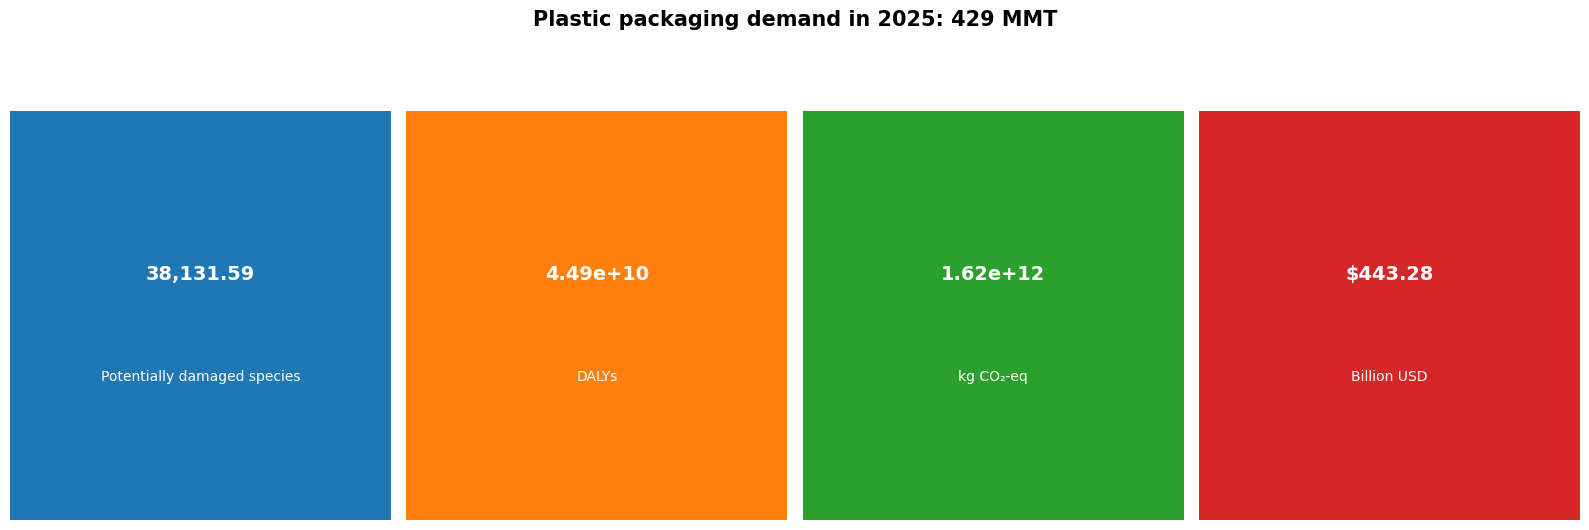

In [77]:
import matplotlib.pyplot as plt

# Example values (replace with your actual variables)
plastic_demand = 429   # MMT
biodiversity_loss = phi[1]
human_health = phi[2]
ghg = phi[0]
cost = total_variable_cost/1e9   # convert to Billion $

# Prepare data
metrics = [
    ("Marine biodiversity loss", f"{biodiversity_loss:,.2f}", "Potentially damaged species"),
    ("Human health impacts", f"{human_health:,.2e}", "DALYs"),
    ("Global warming potential", f"{ghg:,.2e}", "kg CO₂-eq"),
    ("Total variable cost", f"${cost:,.2f}", "Billion USD")
]

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

for ax, (title, value, unit), color in zip(axes, metrics, colors):
    ax.set_facecolor(color)
    ax.text(0.5, 0.6, value, ha="center", va="center", fontsize=14, weight="bold", color="white")
    ax.text(0.5, 0.35, unit, ha="center", va="center", fontsize=10, color="white")
    ax.set_title(title, fontsize=11, color="white", pad=10)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Add a big title with demand
plt.suptitle(f"Plastic packaging demand in 2025: {plastic_demand} MMT",
             fontsize=15, weight="bold", y=1.05)

plt.tight_layout()
plt.show()

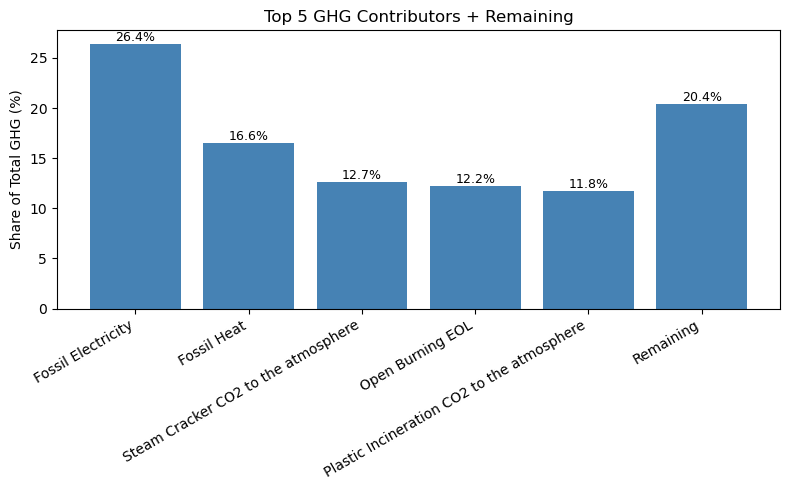

In [65]:
import matplotlib.pyplot as plt

# ---- use the grouped dataframe you already built ----
df_grouped_sorted = df_grouped.sort_values("share_%", ascending=False)

# Top 5 contributors
top5 = df_grouped_sorted.head(5).copy()

# Add "Remaining"
remaining_share = 100 - top5["share_%"].sum()
remaining_row = pd.DataFrame({"grouped_name": ["Remaining"], "share_%": [remaining_share]})

plot_df = pd.concat([top5[["grouped_name", "share_%"]], remaining_row], ignore_index=True)

# ---- plotting ----
plt.figure(figsize=(8, 5))
bars = plt.bar(plot_df["grouped_name"], plot_df["share_%"], color="steelblue")

# Annotate bars with percentages
for bar, val in zip(bars, plot_df["share_%"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{val:.1f}%", ha="center", va="bottom", fontsize=9)

plt.title("Top 5 GHG Contributors + Remaining")
plt.ylabel("Share of Total GHG (%)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


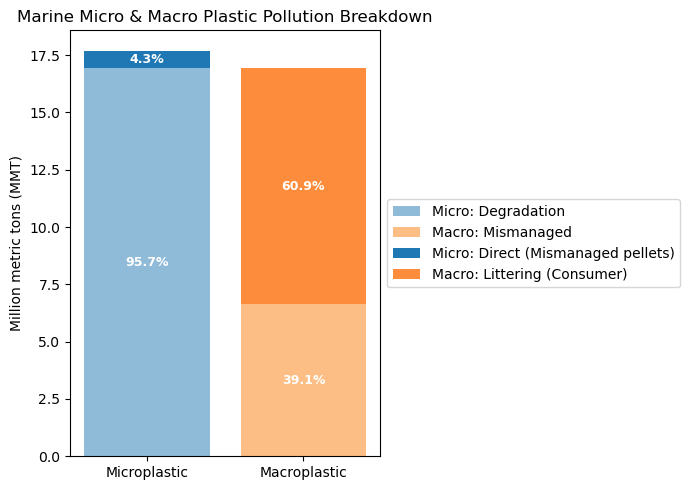

In [79]:
import matplotlib.pyplot as plt

# ---- keys from your computed dicts ----
micro_direct_key = "microplastic_direct_enable"
micro_degrad_key = "microplastic_degradation_enable"

# littering comes from the Use & Collection–only dict
macro_litter = float(
    macro_sums_mmt.get("macro_litter_enable",
                       macro_sums_mmt.get("macroplastic_enable", 0.0))  # fallback
)

# total macro comes from the all-flows dict
macro_total  = float(g_sums.get("macroplastic_enable", 0.0))

# if you also computed an explicit mismanaged key in g_sums, prefer it; otherwise derive
macro_misman = float(g_sums.get("macro_mismanage_enable", max(macro_total - macro_litter, 0.0)))

# micro parts from g_sums (already in MMT)
micro_direct = float(g_sums.get(micro_direct_key, 0.0))
micro_degrad = float(g_sums.get(micro_degrad_key, 0.0))

labels      = ["Microplastic", "Macroplastic"]
bottom_vals = [micro_degrad,   macro_misman]
top_vals    = [micro_direct,   macro_litter]

colors_bottom = ["#8FBBD9", "#FDBE85"]  # degradation, mismanaged
colors_top    = ["#1F77B4", "#FD8D3C"]  # direct/pellets, littering

x = [0, 1]
plt.figure(figsize=(7, 5))

bars_bottom = plt.bar(x, bottom_vals, color=colors_bottom)
bars_top    = plt.bar(x, top_vals, bottom=bottom_vals, color=colors_top)

# Total for each stacked bar
totals = [bottom_vals[i] + top_vals[i] for i in range(len(labels))]

# Annotate with percentages inside each bar segment
for i, bars in enumerate((bars_bottom, bars_top)):
    for j, b in enumerate(bars):
        h = b.get_height()
        if h > 0:
            share = h / totals[j] * 100
            plt.text(
                b.get_x() + b.get_width()/2,
                b.get_y() + h/2,          # halfway inside the bar segment
                f"{share:.1f}%",
                ha="center", va="center", fontsize=9, color="white", weight="bold"
            )

plt.xticks(x, labels)
plt.ylabel("Million metric tons (MMT)")
plt.title("Marine Micro & Macro Plastic Pollution Breakdown")
plt.legend(
    [bars_bottom[0], bars_bottom[1], bars_top[0], bars_top[1]],
    ["Micro: Degradation", "Macro: Mismanaged",
     "Micro: Direct (Mismanaged pellets)", "Macro: Littering (Consumer)"],
    loc="center left", bbox_to_anchor=(1.0, 0.5)
)

plt.tight_layout()
plt.show()


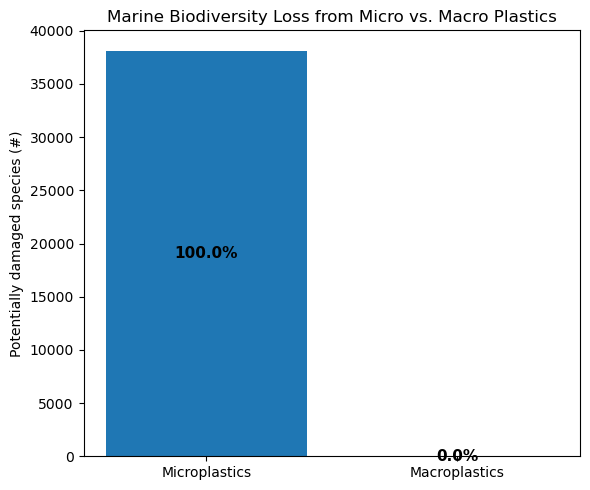

In [75]:
import matplotlib.pyplot as plt

# Example: replace with your actual computed values
# phi1_micro = ...
# phi1_macro = ...
# phi = [...]

# shares in %
share_micro = phi1_micro / phi[1] * 100 if phi[1] != 0 else 0
share_macro = phi1_macro / phi[1] * 100 if phi[1] != 0 else 0

# plot absolute numbers (species potentially damaged), but label with %
vals = [phi1_micro, phi1_macro]
labels = ["Microplastics", "Macroplastics"]
colors = ["#1F77B4", "#FD8D3C"]

plt.figure(figsize=(6,5))
bars = plt.bar(labels, vals, color=colors)

# annotate with % share inside bars
for bar, share in zip(bars, [share_micro, share_macro]):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             h/2, f"{share:.1f}%",   # percent label
             ha="center", va="center", color="black", fontsize=11, weight="bold")

plt.ylabel("Potentially damaged species (#)")
plt.title("Marine Biodiversity Loss from Micro vs. Macro Plastics")
plt.tight_layout()
plt.show()